In [1]:
# install the required module for image classification 
!pip install tensorflow opencv-python matplotlib

In [2]:
# verifying the installaed module with the version 
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
alabaster                     0.7.12
alembic                       1.11.1
anaconda-client               1.11.0
anaconda-navigator            2.3.1
anaconda-project              0.11.1
anyio                         3.5.0
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arrow                         1.2.2
astroid                       2.11.7
astropy                       5.1
astunparse                    1.6.3
atomicwrites                  1.4.0
attrs                         21.4.0
Automat                       20.2.0
autopep8                      1.6.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
backports.tempfile            1.0
backports.weakref             1.0.post1
bcrypt                        3.2.0
beautifulsoup4                4.11.1
b

In [3]:
import tensorflow as tf # tensorflow api for model building and training
import os # os pkg for handling data from local directory
import warnings
warnings.filterwarnings('ignore')

C:\Users\DELL\anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
# use set_memory_growth(gpu, True) from tf.config.experimental to avoid Out of memeory error in case using GPU

### Load required libraries 

In [34]:
import cv2 # to read images from local directory to memory as array 
import imghdr # to check the image extension.

import numpy as np # for array relaated operations
from matplotlib import pyplot as plt # to show / plot loaded images

from tensorflow.keras.models import Sequential # to build a sequential model 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense # to add different layers for CNN model

from tensorflow.keras.metrics import Precision, Recall, Accuracy, SparseCategoricalAccuracy # to evulate the trained model

from tensorflow.keras.models import load_model # to load the saved model from local directory

### Remove currupted and unsupported data

- the dataset is downloaded from kaggle -> https://www.kaggle.com/datasets/puneet6060/intel-image-classification/data

In [9]:
data_dir = 'dataset' # path where the data is stored
train_dir = 'train' # path of training data 
#test_dir = 'test'
#prediction_dir = 'prediction'

In [11]:
img_extensions = ['jpeg', 'jpg', 'bmp', 'png'] # type of images allowed for model training

for img_class in os.listdir(os.path.join(data_dir, train_dir)):
    for img in os.listdir(os.path.join(data_dir, train_dir, img_class)):
        img_path = os.path.join(data_dir, train_dir, img_class, img)
        #print(img_path)
        
        try:
            img = cv2.imread(img_path) # return the image as array
            tip = imghdr.what(img_path) # return the extension of image
            
            if tip not in img_extensions:
                print('image extenstion not in provided list {}'.format(img_path))
                os.remove(img_path) # remove the image if the image extension not in the provided list
                      
        except Exception as e:
            print('issue while loading image {}'.format(img_path))
            

In [ ]:
#tf.data.Dataset?? # way to check the documentation of specific methods

### Load data

In [13]:
# to load the image data from local directorry to memory on-fly
# makee sure to specify the image_size and batch_size as per your data

# here i am only using the train dir to train model in order to learn how to split the data into train, test, val in case the
# data is located into one directory.
# if the data is already seperated in the train, test and val use different generator object 

data = tf.keras.utils.image_dataset_from_directory(
    directory= os.path.join(data_dir,train_dir),
    image_size=(150,150) 
)

data

Found 14034 files belonging to 6 classes.


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [18]:
# the below code is only for verifying the images and labels are loaded properly 

data_iterator = data.as_numpy_iterator() # create a data iterator to iterate over generated dataset 
data_batch = data_iterator.next() # retrive the batch of data as the data is shuffled we can retrive different images on every load

print(len(data_batch)) # the len of data batch is 2 becuase it stores 2 parts the 1st one is batch of images and 2nd one is correcponding labels
print(data_batch[0].shape) # return the shape of batch
print(data_batch[1]) # return the labels. labels depends on the type you have selected while loading data from directory

# the labels are alphabetically sequenced while generating the dataset
class_labels = os.listdir(os.path.join(data_dir,train_dir))

2
(32, 150, 150, 3)
[1 1 5 2 4 4 1 0 3 1 4 0 3 1 1 3 1 0 3 5 2 4 4 3 4 2 0 0 4 0 2 4]


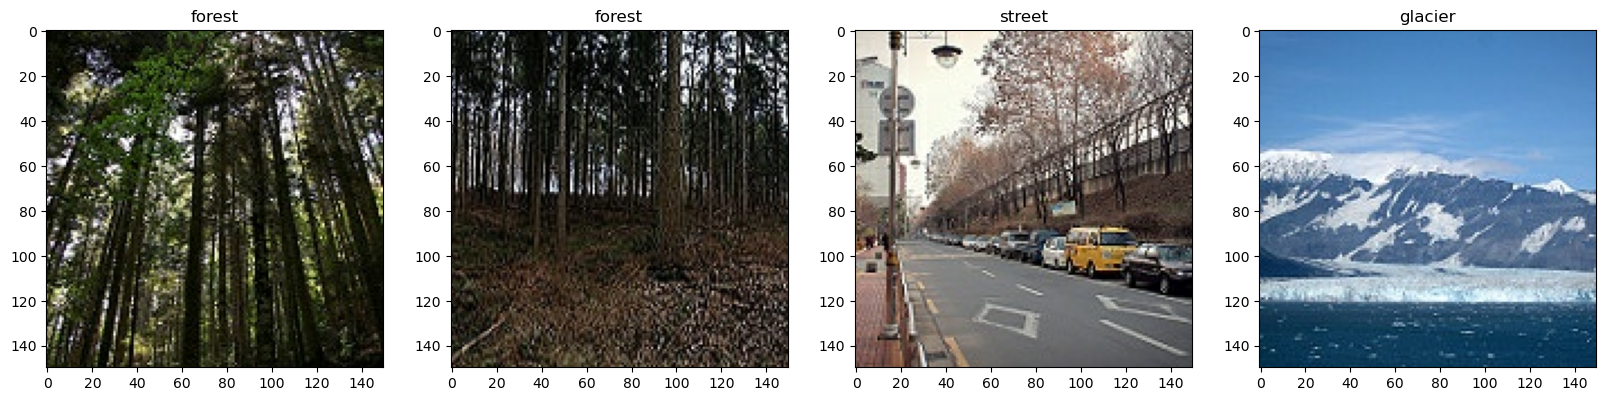

In [19]:
# plotting loaded images to verify everything is ok
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 

for idx, img in enumerate(data_batch[0][:4]): # iterating over image array from 0 to 4 i.e 4 images 
    ax[idx].imshow(img.astype(int)) # always make sure the type while showing image if the image is normalized use astype(float)
    ax[idx].title.set_text(class_labels[data_batch[1][idx]])

### Preprocess and Prepare data for training

In [20]:
# scaling of data # don't run this cell twice or thrice as it normalize the data that many times. also always verify the data is properly preproceed before model training
data = data.map(lambda x,y: (x/255.0, y)) # the map functions helps to perform map transformation to each and every image and label

In [21]:
# just to verify the data transformation applied properly
scaled_data_iterator = data.as_numpy_iterator() 
scaled_data_batch = scaled_data_iterator.next() 

scaled_data_batch[0].max()

1.0

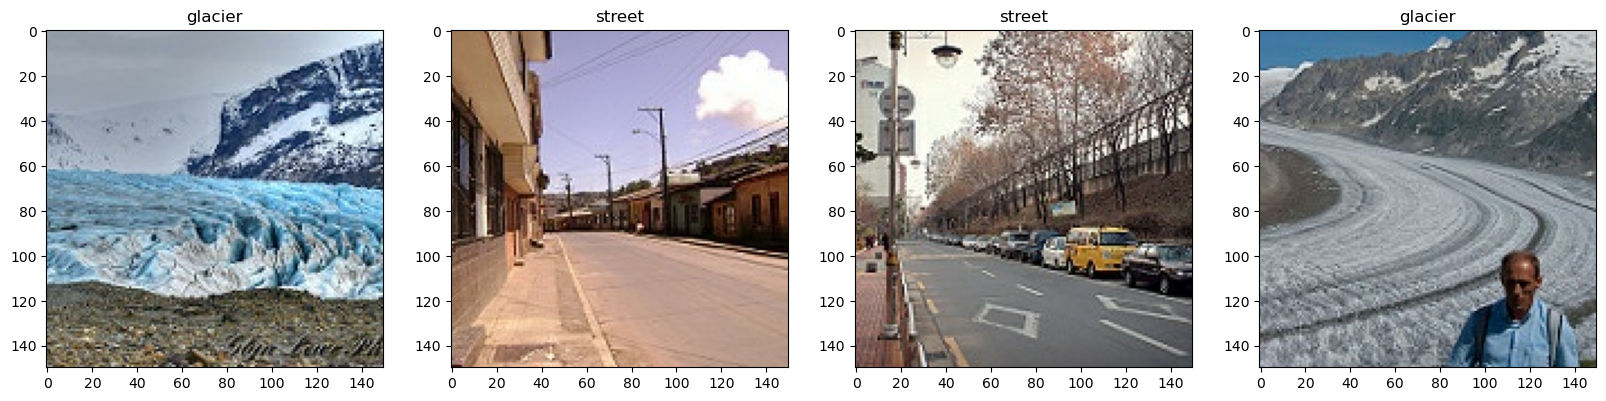

In [22]:
# plotting processed images to verify the applied transformation is ok
fig, ax = plt.subplots(ncols=4, figsize=(20,20)) 

for idx, img in enumerate(scaled_data_batch[0][:4]): # iterating over image array from 0 to 4 i.e 4 images 
    ax[idx].imshow(img.astype(float)) # always make sure the type while showing image if the image is normalized use astype(float)
    ax[idx].title.set_text(class_labels[scaled_data_batch[1][idx]])

### Split the dataset for training testing and validation

In [23]:
total_batches =  len(data) # we have 439 batches and each batch consisting 32 images
train_size = int(total_batches *.7) # allote 70% of batches for training 
val_size = int(total_batches * .2) # allote 20% of batches for val
test_size = total_batches - train_size - val_size # allote remaining batches for testing

print(train_size, val_size, test_size)

# if you have different directory for train, test, and val you have to use 3 generator with 3 directory path
# the above logic is used only when you have all data into one folder and you want to split the data for train, test and val

307 87 45


In [24]:
# assign the number of batches we have splitted earlier to train, test and val
train_data = data.take(train_size) # we are taking / alloting first train_size i.e 307 batches for train_data
val_data = data.skip(train_size).take(val_size) # we are skipping first train_size i.e 307 batches and taking next val_size i.e 87 batches for val
test_data = data.skip(train_size + val_size).take(test_size)

print(len(train_data), len(val_data), len(test_data))

307 87 45


### Build the model

In [25]:
model = Sequential()

model.add(Conv2D(filters= 16, kernel_size= (3,3), activation='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters= 32, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(filters= 16, kernel_size= (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(units= 256, activation='relu'))
model.add(Dense(units= len(class_labels), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 16)        0

In [28]:
# we have specified label_mode = int (which is by default) while loading the data we have to use loss function as sparse_categorical_crossentropy
# also read more about label_model and loss function image_dataset_from_directory method or keras documentation 
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [29]:
logdir = 'logs' # to store logs of model training
tensorboard_callbacks = tf.keras.callbacks.TensorBoard(log_dir= logdir) # helps to store the model training logs into a dir
# this will helps to save a model on particular checkpoint, to fetect the particular epocs log and many more
# also use checkpoints callback to store model training checkpoint which can help you to load model or retrain model from particular steps

In [30]:
# train the model using loaded data
hist = model.fit(train_data, epochs=10, validation_data= val_data, callbacks=[tensorboard_callbacks])

Epoch 1/10
307/307 [==============================] - 122s 390ms/step - loss: 1.0415 - sparse_categorical_accuracy: 0.5958 - val_loss: 0.8440 - val_sparse_categorical_accuracy: 0.6570
Epoch 2/10
307/307 [==============================] - 120s 389ms/step - loss: 0.7497 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.6687 - val_sparse_categorical_accuracy: 0.7489
Epoch 3/10
307/307 [==============================] - 115s 374ms/step - loss: 0.6237 - sparse_categorical_accuracy: 0.7764 - val_loss: 0.6341 - val_sparse_categorical_accuracy: 0.7532
Epoch 4/10
307/307 [==============================] - 112s 363ms/step - loss: 0.5255 - sparse_categorical_accuracy: 0.8114 - val_loss: 0.5825 - val_sparse_categorical_accuracy: 0.7841
Epoch 5/10
307/307 [==============================] - 109s 353ms/step - loss: 0.4394 - sparse_categorical_accuracy: 0.8401 - val_loss: 0.6067 - val_sparse_categorical_accuracy: 0.7672
Epoch 6/10
307/307 [==============================] - 116s 376ms/step - loss: 0.

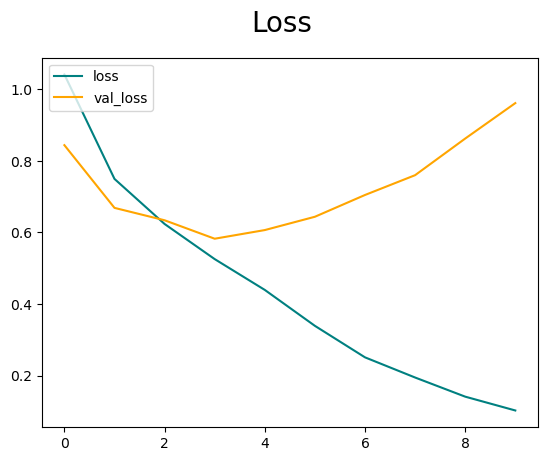

In [31]:
# to plot the loss plot in order to understand how loss changes per epoch
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

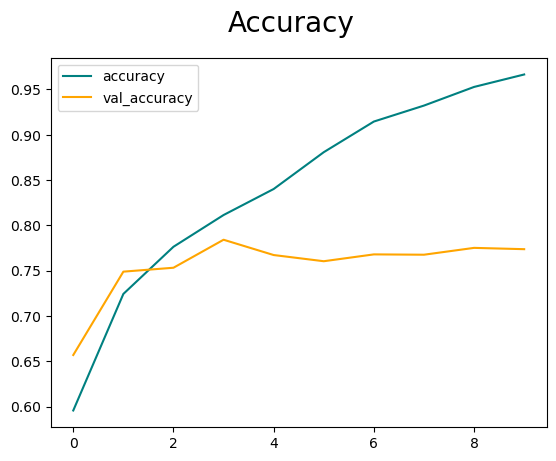

In [33]:
# to plot the accuracy plot in order to understand how accuracy affeccted per epoch
fig = plt.figure()
plt.plot(hist.history['sparse_categorical_accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_sparse_categorical_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

- we can observe that after 3 epochs the validation loss start incresing and the val accuracy remains same.
- this mean that we either have to modify the network we have develope or need to focus on other model regularization and generalization techniques such as data augmentation, adaptive learning rate, layer regularization and normalization 

### Model evalution 

In [37]:
# let's use tensorflow metrices to evaluate the model 
pre = Precision()
rec = Recall()
acc = Accuracy()

In [38]:
# let's test our model on test data to understand how much accurate our model is on unseen data 
len(test_data)
for test_batch in test_data:
    X,y = test_batch
    
    yhat = model.predict(X)
    yhat = tf.argmax(yhat, axis=1)
    
    #print(yhat.shape, y.shape)
    
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)    
    

1/1 [==============================] - 0s 299ms/step


In [39]:
print(f'Accuracy : {acc.result().numpy()}')
print(f'Precision : {pre.result().numpy()}')
print(f'Recall : {rec.result().numpy()}')

Accuracy : 0.7868162989616394
Precision : 0.9532943964004517
Recall : 0.9524999856948853


### Test model on totally new and unseen data

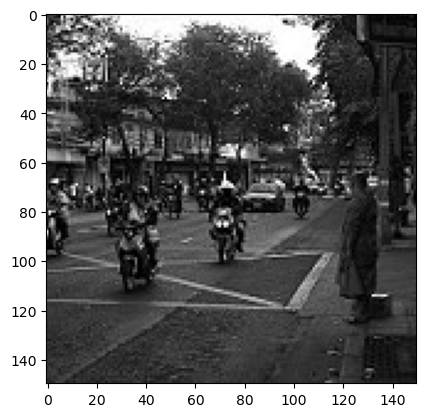

In [45]:
img_path = 'dataset/prediction/3.jpg'
img = cv2.imread(img_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

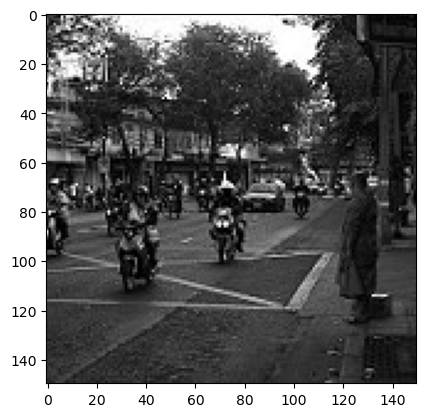

In [46]:
img = tf.image.resize(img,(150,150))
plt.imshow(img.numpy().astype('int')) # as cv2 red image as BGR and plt uses RGB to plot image hence it looks something weird

In [48]:
# as our model trained on the batch of data hence first we have to expand the dimension of our image 
# second, we have to normalize the image as while training we have normalized the data at the time of preprocessing
# third step is to find the largest or max possible value from the set of values for that we have to use argmax either from np or tf
yhat = tf.argmax(model.predict(np.expand_dims((img/255),0)), axis=1).numpy()[0]
print(class_labels[yhat])

1/1 [==============================] - 0s 51ms/step
street


### Save the model

In [49]:
model.save(os.path.join('saved models','1_intel_image_classification_model.h5'))

### Load the model from directory

In [50]:
model_name = '1_intel_image_classification_model.h5'
model_dir = 'saved models'
loaded_model = load_model(os.path.join(model_dir, model_name))
loaded_model

In [51]:
yhat = tf.argmax(loaded_model.predict(np.expand_dims((img/255),0)), axis=1).numpy()[0]
print(class_labels[yhat])

1/1 [==============================] - 0s 140ms/step
street
